In [4]:
!pip install pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 939.1 kB/s eta 0:00:00a 0:00:01


In [7]:
import numpy as np
import pandas as pd

import pickle5 as pickle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [8]:
with open("../input/tobigsmall2/total_data.pkl", 'rb') as f:
    totaldata = pickle.load(f).reset_index(drop=True)

X1=totaldata['tag_embedding']
X2=totaldata['mel_embedding']


In [14]:
X3 = totaldata.iloc[:,4:259]

In [15]:
X4 = totaldata['singer']

In [16]:
data = {
    'First' : ['0'],
    'Second' : ['0'],
    'Simiarity' : [0]
}
X_cosine = pd.DataFrame(data)

In [17]:
def cos_sim(A, B):
  return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))

In [18]:
# 랜덤한 10000쌍 생성

import random
data = {
    'First' : [0],
    'Second' : [0]
}
pair = pd.DataFrame(data)

n = 100000

for i in tqdm(range(n)):
  a = random.randrange(0,n)
  b = random.randrange(0,n)
  data ={'First':a, 'Second':b}
  pair = pair.append(data,ignore_index=True)
    
pair = pair[1:]

#중복데이터 확인
pair[pair.duplicated(keep='last')]

100%|██████████| 10000/10000 [00:11<00:00, 883.81it/s]


,First,Second


In [19]:
list_sim = []

for i in tqdm(range(len(pair))):
    a = pair.iloc[i]['First']
    b = pair.iloc[i]['Second']
    ijcos = cos_sim(X1[a],X1[b])
    list_sim.append(ijcos)

#태그간 코사인 유사도
pair.loc[:,'Sim'] = list_sim

100%|██████████| 10000/10000 [00:02<00:00, 4725.64it/s]


In [24]:
# 넘파이 할당
X1_new = np.zeros((n,256))
X2_new = np.zeros((n,48,20))
X3_new = np.zeros((n, 255))
X4_new = np.zeros((n, 1))

for i in tqdm(range(n)):
  a = pair.iloc[i]['First'] 
  b = pair.iloc[i]['Second']
  X1_new[i] = X1[int(a)] #tag
  X2_new[i] = X2[int(b)] #mel
  X3_new[i] = X3.iloc[int(b),:] #mel과 함께 움직임
  X4_new[i] = X4.iloc[int(b)]
    
y_new = pair['Sim']
#y_new = y_new.iloc[:-1]

In [25]:
X1 = X1_new
X2 = X2_new
X3 = X3_new
X4 = X4_new
y = y_new

In [26]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=1)
X1_train, X1_val, y_train, y_val = train_test_split(X1_train, y_train, test_size=0.25, random_state=1)


X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=1)
X2_train, X2_val, y_train, y_val = train_test_split(X2_train, y_train, test_size=0.25, random_state=1)

X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=1)
X3_train, X3_val, y_train, y_val = train_test_split(X3_train, y_train, test_size=0.25, random_state=1)

X4_train, X4_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=1)
X4_train, X4_val, y_train, y_val = train_test_split(X4_train, y_train, test_size=0.25, random_state=1)

In [27]:
import h5py
import os, shutil
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Model
from keras.layers import Add, Activation, Concatenate, Conv2D, Dropout 
from keras.layers import Flatten, Input, GlobalAveragePooling2D, MaxPooling2D

In [44]:
# SqeezeNet
bnmomemtum=0.9
dropout_rate = 0.2
initializer = keras.initializers.HeUniform(seed = 21)


def fire(x, squeeze, expand):
    y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
    y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
    y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
    y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
    y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
    y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
    return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
    return lambda z: fire(z, squeeze, expand)




mel_input = keras.Input(shape=(48,20,1), name="mel")

x2 = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(mel_input)
x2 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(x2)
x2 = fire_module(24, 48)(x2)
x2 = tf.keras.layers.MaxPooling2D(pool_size=2)(x2)
x2 = fire_module(48, 96)(x2)
x2 = tf.keras.layers.MaxPooling2D(pool_size=2)(x2)
x2 = fire_module(64, 128)(x2)
x2 = tf.keras.layers.MaxPooling2D(pool_size=2)(x2)
x2 = fire_module(48, 96)(x2)
x2 = tf.keras.layers.MaxPooling2D(pool_size=2)(x2)
x2 = fire_module(24, 48)(x2)
x2 = tf.keras.layers.GlobalAveragePooling2D()(x2)

gen_input = keras.Input(shape=(255,), name="gen")

x2 = tf.keras.layers.Concatenate()([gen_input, x2])

singer_input = keras.Input(shape=(1,), name='singer')
x4 = layers.Embedding(120358,4)(singer_input)
x4 = layers.Flatten()(x4)


x2 = tf.keras.layers.Concatenate()([x4, x2])

x2 = layers.Dense(512, activation="relu",kernel_initializer=initializer)(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dropout(dropout_rate)(x2)
x2 = layers.Dense(256, activation="relu",kernel_initializer=initializer)(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dropout(dropout_rate)(x2)
x2 = layers.Dense(128, activation="relu",kernel_initializer=initializer)(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dropout(dropout_rate)(x2)
x2 = layers.Dense(64, activation="relu",kernel_initializer=initializer)(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dropout(dropout_rate)(x2)
x2 = layers.Dense(32, activation="relu",kernel_initializer=initializer)(x2)
x2 = layers.BatchNormalization(trainable=True)(x2)
x2 = layers.Dense(16,kernel_initializer=initializer)(x2)

tag_input = keras.Input(shape=(256,), name="tag")

x1 = layers.Dense(256, activation="relu",kernel_initializer=initializer)(tag_input)
x1 = layers.BatchNormalization(trainable=True)(x1)
x1 = layers.Dropout(0.2)(x1)
x1 = layers.Dense(128, activation="relu",kernel_initializer=initializer)(x1)
x1 = layers.BatchNormalization(trainable=True)(x1)
x1 = layers.Dropout(0.2)(x1)
x1 = layers.Dense(64, activation="relu",kernel_initializer=initializer)(x1)
x1 = layers.BatchNormalization(trainable=True)(x1)
x1 = layers.Dropout(0.2)(x1)
x1 = layers.Dense(32, activation="relu",kernel_initializer=initializer)(x1)
x1 = layers.BatchNormalization(trainable=True)(x1)

x1 = layers.Dense(16,kernel_initializer=initializer)(x1)

x3  = tf.keras.layers.Dot(axes=1,normalize=True)([x1, x2])

model = keras.Model(inputs=[tag_input,mel_input,gen_input,singer_input], outputs=x3, name="model")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mel (InputLayer)                [(None, 48, 20, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 48, 20, 32)   320         mel[0][0]                        
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 48, 20, 32)   128         conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 48, 20, 24)   792         batch_normalization_50[0][0]     
______________________________________________________________________________________________

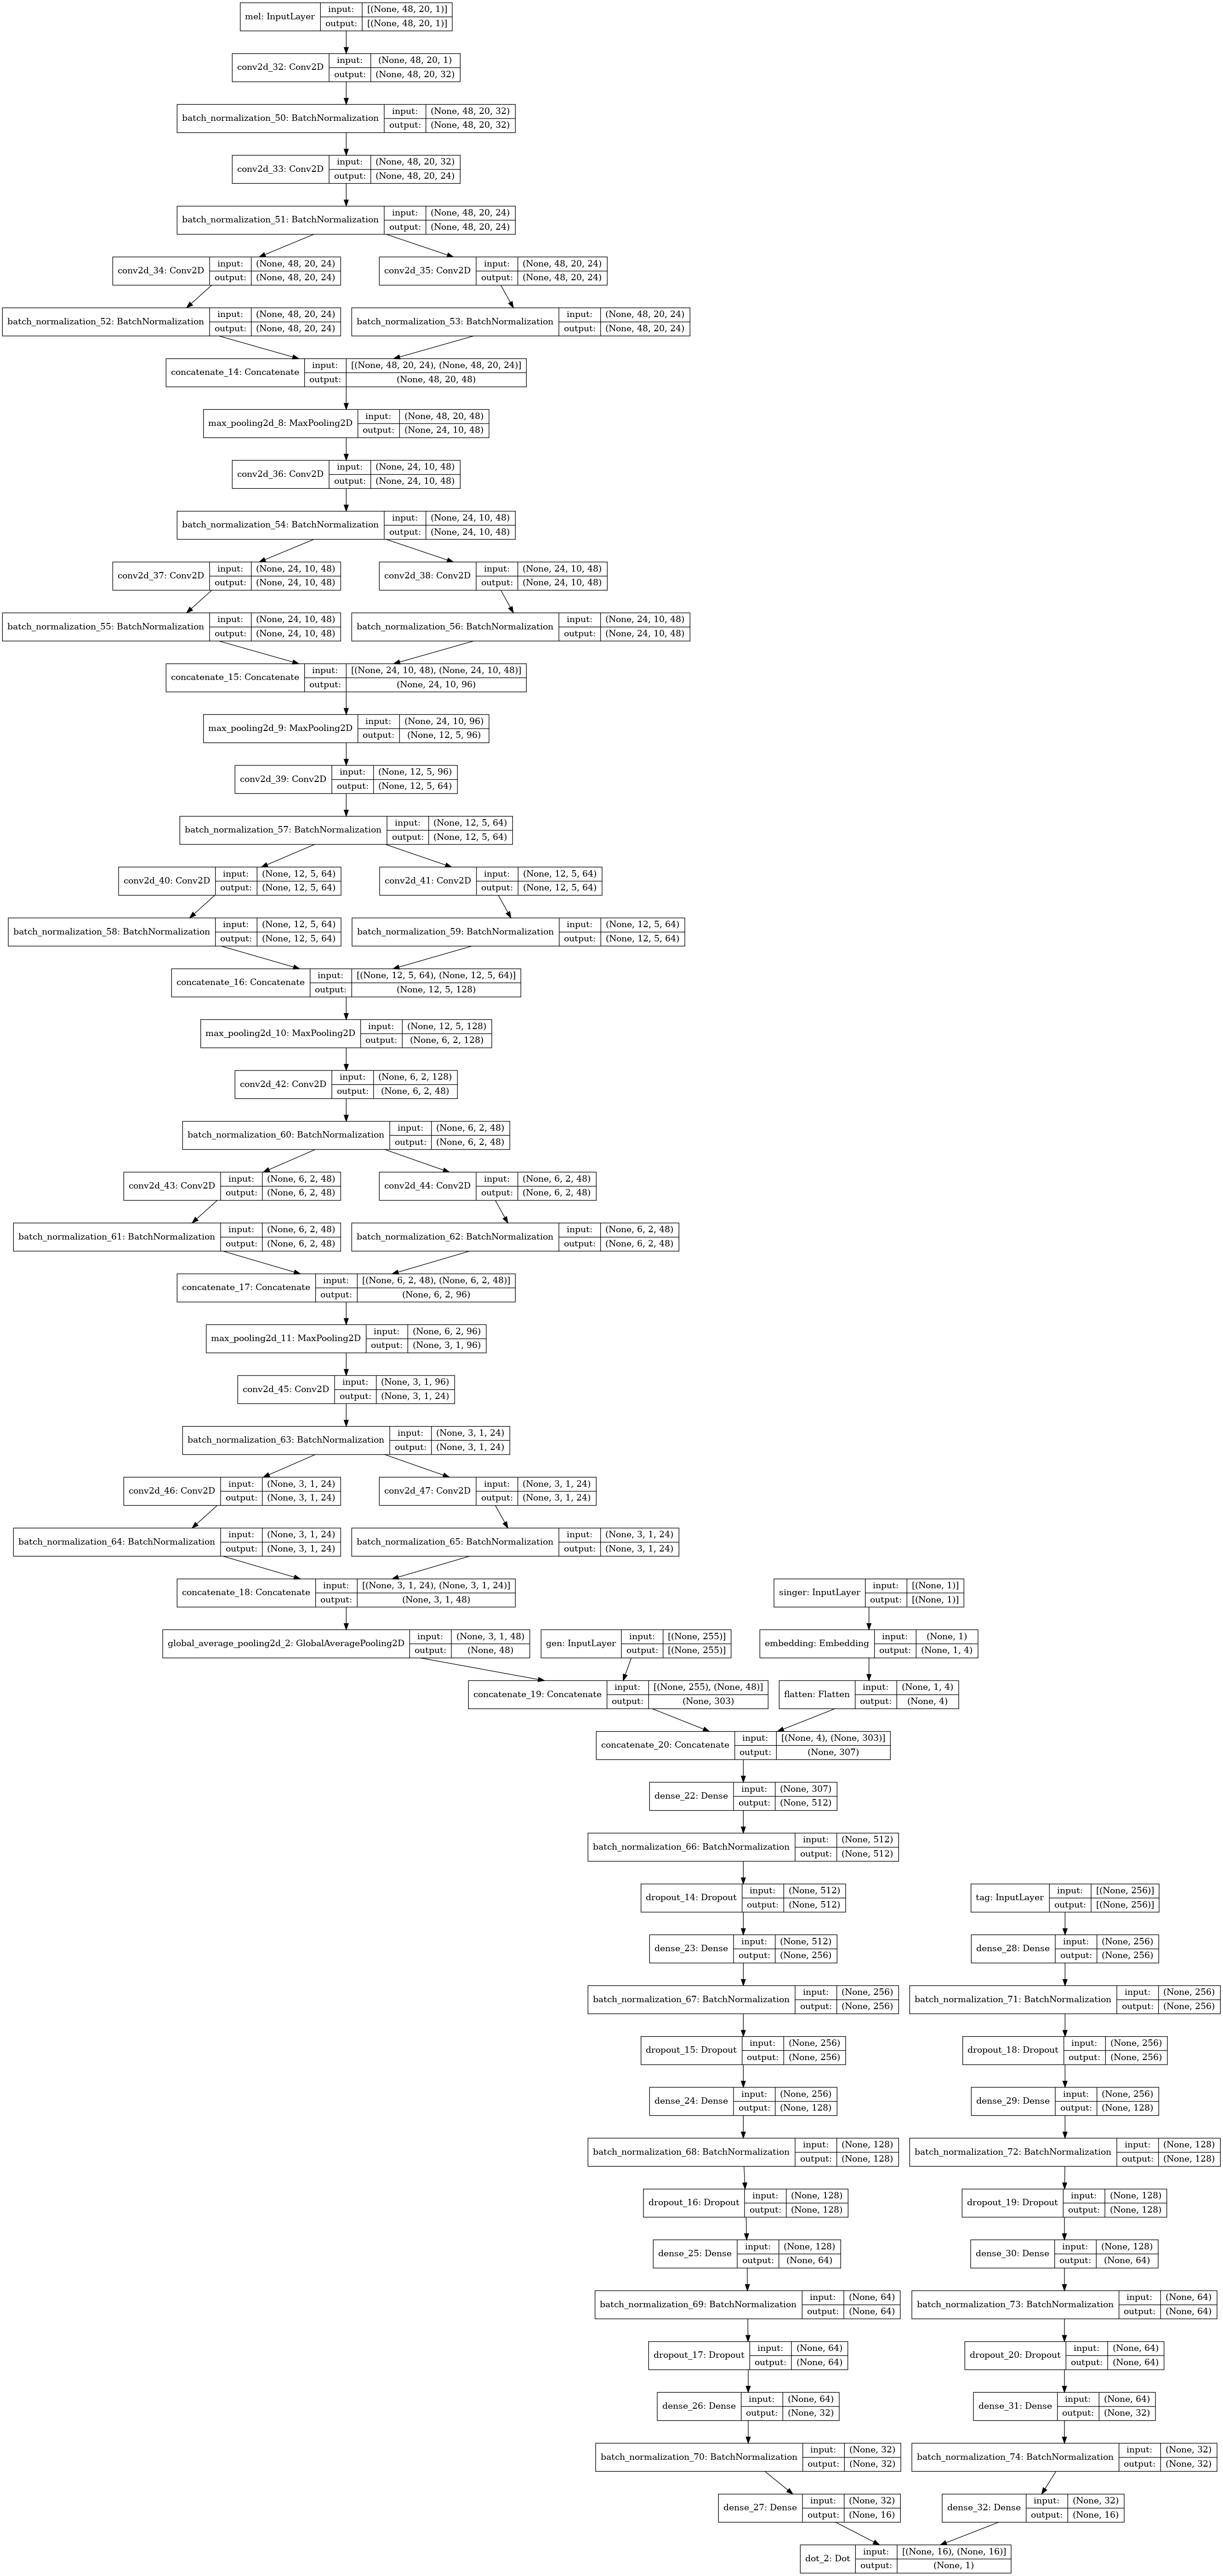

In [45]:
keras.utils.plot_model(model, "model.png", show_shapes=True)

In [46]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

early_stoping_callback = EarlyStopping(monitor='val_loss',patience=5,
                                      restore_best_weights=True)


from keras.utils import multi_gpu_utils


optimizer = keras.optimizers.Adam(lr=0.01, decay = 0.001)
with tf.device('/gpu:0'):
    model.compile(optimizer=optimizer,
                  loss= tf.keras.losses.MeanSquaredError()   , #tf.keras.losses.MeanSquaredError()   contrastive_loss
                  metrics=[tf.keras.metrics.MeanSquaredError()]) #

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [47]:
BATCH_SIZE = 256
EPOCHS = 20



result = model.fit([X1_train,X2_train,X3_train,X4_train] ,y_train, epochs=EPOCHS, 
                   validation_data = ([X1_val,X2_val,X3_val,X4_val] ,y_val), batch_size=BATCH_SIZE,
                  callbacks=[early_stoping_callback]) 

Epoch 1/20
24/24 [==============================] - 15s 458ms/step - loss: 0.5943 - mean_squared_error: 0.5943 - val_loss: 0.1614 - val_mean_squared_error: 0.1614
Epoch 2/20
24/24 [==============================] - 10s 416ms/step - loss: 0.0650 - mean_squared_error: 0.0650 - val_loss: 0.0393 - val_mean_squared_error: 0.0393
Epoch 3/20
24/24 [==============================] - 11s 442ms/step - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0159 - val_mean_squared_error: 0.0159
Epoch 4/20
24/24 [==============================] - 10s 418ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - val_loss: 0.0163 - val_mean_squared_error: 0.0163
Epoch 5/20
24/24 [==============================] - 10s 415ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 6/20
24/24 [==============================] - 10s 435ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - val_loss: 0.0119 - val_mean_squared_error: 0.0119
Epoch 7/20
24/24 [====

In [48]:
model.save("squeeze_model.h5")

In [49]:
y_pred = model.predict(x = (X1_val,X2_val,X3_val,X4_val))
y_pred.reshape(-1)

array([0.83063555, 0.88635767, 0.77365637, ..., 0.84756255, 0.8086473 ,
       0.85101914], dtype=float32)

In [50]:
from sklearn.metrics import ndcg_score

ndcg_score(np.asarray([y_val]),np.array(y_pred).T)

0.98885717636775

In [51]:
from scipy import stats

tau, p_value = stats.kendalltau(y_val, y_pred)

print(tau, p_value)

0.2608163637374351 2.018423747637735e-68


In [52]:
graph_data = pd.DataFrame({ "y_true" : np.asarray(y_val), "y_pred" : y_pred.reshape(-1)})

graph_data['diff'] = abs(graph_data['y_true'] - graph_data['y_pred'])

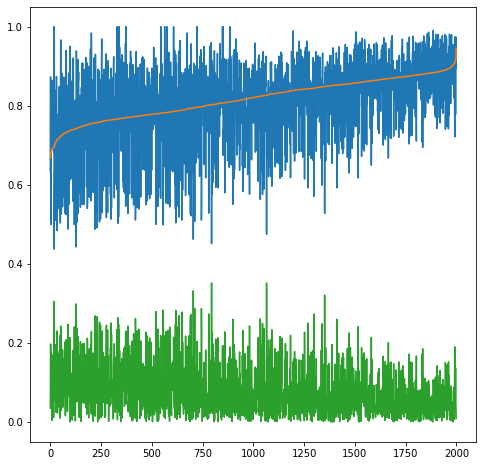

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.plot(graph_data.sort_values(by=['y_pred']).reset_index(drop=True))
plt.show()
